Note: Much code taken from Neuromatch NeuroAI 2024 Microlearning.

In [41]:
# dependencies
from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io

from helpers import sigmoid, ReLU, add_bias, create_batches, calculate_accuracy, calculate_cosine_similarity

In [42]:
# Download MNIST function
def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    
    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform)
    full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform)
    
    full_train_images = full_train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (full_test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(full_train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(full_test_set.targets, num_classes=10).numpy().T

    train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set, [train_prop * keep_prop, valid_prop * keep_prop, discard_prop])
    test_set, _ = torch.utils.data.random_split(
      full_test_set, [keep_prop, discard_prop])

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels

In [43]:
train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels = download_mnist()

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


## Backpropagation

In [44]:
# define the model
NUM_INPUTS = np.product(train_set.dataset.data[0].shape) # size of an MNIST image
NUM_OUTPUTS = 10 # number of MNIST classes

class MultiLayerPerceptron(torch.nn.Module):
  """
  Simple multilayer perceptron model class with one hidden layer.
  """

  def __init__(
      self,
      num_inputs=NUM_INPUTS,
      num_hidden=100,
      num_outputs=NUM_OUTPUTS,
      activation_type="sigmoid",
      bias=False,
      ):
    """
    Initializes a multilayer perceptron with a single hidden layer.

    Arguments:
    - num_inputs (int, optional): number of input units (i.e., image size)
    - num_hidden (int, optional): number of hidden units in the hidden layer
    - num_outputs (int, optional): number of output units (i.e., number of
      classes)
    - activation_type (str, optional): type of activation to use for the hidden
      layer ('sigmoid', 'tanh', 'relu' or 'linear')
    - bias (bool, optional): if True, each linear layer will have biases in
      addition to weights
    """


    super().__init__()

    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs
    self.activation_type = activation_type
    self.bias = bias

    # default weights (and biases, if applicable) initialization is used
    # see https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/linear.py
    self.lin1 = torch.nn.Linear(num_inputs, num_hidden, bias=bias)
    self.lin2 = torch.nn.Linear(num_hidden, num_outputs, bias=bias)

    self._store_initial_weights_biases()

    self._set_activation() # activation on the hidden layer
    self.softmax = torch.nn.Softmax(dim=1) # activation on the output layer


  def _store_initial_weights_biases(self):
    """
    Stores a copy of the network's initial weights and biases.
    """

    self.init_lin1_weight = self.lin1.weight.data.clone()
    self.init_lin2_weight = self.lin2.weight.data.clone()
    if self.bias:
      self.init_lin1_bias = self.lin1.bias.data.clone()
      self.init_lin2_bias = self.lin2.bias.data.clone()

  def _set_activation(self):
    """
    Sets the activation function used for the hidden layer.
    """

    if self.activation_type.lower() == "sigmoid":
      self.activation = torch.nn.Sigmoid() # maps to [0, 1]
    elif self.activation_type.lower() == "tanh":
      self.activation = torch.nn.Tanh() # maps to [-1, 1]
    elif self.activation_type.lower() == "relu":
      self.activation = torch.nn.ReLU() # maps to positive
    elif self.activation_type.lower() == "identity":
      self.activation = torch.nn.Identity() # maps to same
    else:
      raise NotImplementedError(
          f"{self.activation_type} activation type not recognized. Only "
          "'sigmoid', 'relu' and 'identity' have been implemented so far."
          )

  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets. This variable is not used
      here. However, it may be needed for other learning rules, to it is
      included as an argument here for compatibility.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred

  def forward_backprop(self, X):
    """
    Identical to forward(). Should not be overwritten when creating new
    child classes to implement other learning rules, as this method is used
    to compare the gradients calculated with other learning rules to those
    calculated with backprop.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred


  def list_parameters(self):
    """
    Returns a list of model names for a gradient dictionary.

    Returns:
    - params_list (list): List of parameter names.
    """

    params_list = list()

    for layer_str in ["lin1", "lin2"]:
      params_list.append(f"{layer_str}_weight")
      if self.bias:
        params_list.append(f"{layer_str}_bias")

    return params_list


  def gather_gradient_dict(self):
    """
    Gathers a gradient dictionary for the model's parameters. Raises a
    runtime error if any parameters have no gradients.

    Returns:
    - gradient_dict (dict): A dictionary of gradients for each parameter.
    """

    params_list = self.list_parameters()

    gradient_dict = dict()
    for param_name in params_list:
      layer_str, param_str = param_name.split("_")
      layer = getattr(self, layer_str)
      grad = getattr(layer, param_str).grad
      if grad is None:
        raise RuntimeError("No gradient was computed")
      gradient_dict[param_name] = grad.detach().clone().numpy()

    return gradient_dict

In [45]:
# initialize model and dataloaders

# Model
NUM_HIDDEN = 100
ACTIVATION = "sigmoid" # output constrained between 0 and 1
BIAS = False

MLP_Backprop = MultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
    )


# Dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
# defining an SGD Optimizer
class BasicOptimizer(torch.optim.Optimizer):
  """
  Simple optimizer class based on the SGD optimizer.
  """
  def __init__(self, params, lr=0.01, weight_decay=0):
    """
    Initializes a basic optimizer object.

    Arguments:
    - params (generator): Generator for torch model parameters.
    - lr (float, optional): Learning rate.
    - weight_decay (float, optional): Weight decay.
    """

    if lr < 0.0:
        raise ValueError(f"Invalid learning rate: {lr}")
    if weight_decay < 0.0:
        raise ValueError(f"Invalid weight_decay value: {weight_decay}")

    defaults = dict(
        lr=lr,
        weight_decay=weight_decay,
        )

    super().__init__(params, defaults)

  def step(self):
      """
      Performs a single optimization step.
      """

      for group in self.param_groups:
        for p in group["params"]:

          # only update parameters with gradients
          if p.grad is not None:

            # apply weight decay to gradient, if applicable
            if group["weight_decay"] != 0:
              p.grad = p.grad.add(p, alpha=group["weight_decay"])

            # apply gradient-based update
            p.data.add_(p.grad, alpha=-group["lr"])

In [47]:
# initializing SGD optimizer

# note, can add a weight decay term to optimizer as well...
LR = 0.01
backprop_optimizer = BasicOptimizer(MLP_Backprop.parameters(), lr=LR)

In [48]:
#@markdown `train_model(MLP, train_loader, valid_loader, optimizer)`: Main function.
#@markdown Trains the model across epochs. Aggregates loss and accuracy statistics
#@markdown from the training and validation datasets into a results dictionary which is returned.
def train_model(MLP:MultiLayerPerceptron, train_loader, valid_loader, optimizer, num_epochs=5):
  """
  Train a model for several epochs.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - num_epochs (int, optional): Number of epochs to train model.

  Returns:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  """

  results_dict = {
      "avg_train_losses": list(),
      "avg_valid_losses": list(),
      "avg_train_accuracies": list(),
      "avg_valid_accuracies": list(),
  }

  for e in tqdm(range(num_epochs)):
    no_train = True if e == 0 else False # to get a baseline
    latest_epoch_results_dict = train_epoch(
        MLP, train_loader, valid_loader, optimizer=optimizer, no_train=no_train
        )

    for key, result in latest_epoch_results_dict.items():
      if key in results_dict.keys() and isinstance(results_dict[key], list):
        results_dict[key].append(latest_epoch_results_dict[key])
      else:
        results_dict[key] = result # copy latest

  return results_dict


def train_epoch(MLP, train_loader, valid_loader, optimizer, no_train=False):
  """
  Train a model for one epoch.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - no_train (bool, optional): If True, the model is not trained for the
    current epoch. Allows a baseline (chance) performance to be computed in the
    first epoch before training starts.

  Returns:
  - epoch_results_dict (dict): Dictionary storing epoch results on training
    and validation data.
  """

  criterion = torch.nn.NLLLoss()

  epoch_results_dict = dict()
  for dataset in ["train", "valid"]:
    for sub_str in ["correct_by_class", "seen_by_class"]:
      epoch_results_dict[f"{dataset}_{sub_str}"] = {
          i:0 for i in range(MLP.num_outputs)
          }

  MLP.train()
  train_losses, train_acc = list(), list()
  for X, y in train_loader:
    y_pred = MLP(X, y=y)
    loss = criterion(torch.log(y_pred), y)
    acc = (torch.argmax(y_pred.detach(), axis=1) == y).sum() / len(y)
    train_losses.append(loss.item() * len(y))
    train_acc.append(acc.item() * len(y))
    update_results_by_class_in_place(
        y, y_pred.detach(), epoch_results_dict, dataset="train",
        num_classes=MLP.num_outputs
        )
    optimizer.zero_grad()
    if not no_train:
      loss.backward()
      optimizer.step()

  num_items = len(train_loader.dataset)
  epoch_results_dict["avg_train_losses"] = np.sum(train_losses) / num_items
  epoch_results_dict["avg_train_accuracies"] = np.sum(train_acc) / num_items * 100

  MLP.eval()
  valid_losses, valid_acc = list(), list()
  with torch.no_grad():
    for X, y in valid_loader:
      y_pred = MLP(X)
      loss = criterion(torch.log(y_pred), y)
      acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
      valid_losses.append(loss.item() * len(y))
      valid_acc.append(acc.item() * len(y))
      update_results_by_class_in_place(
          y, y_pred.detach(), epoch_results_dict, dataset="valid"
          )

  num_items = len(valid_loader.dataset)
  epoch_results_dict["avg_valid_losses"] = np.sum(valid_losses) / num_items
  epoch_results_dict["avg_valid_accuracies"] = np.sum(valid_acc) / num_items * 100

  return epoch_results_dict


def update_results_by_class_in_place(y, y_pred, result_dict, dataset="train",
                                     num_classes=10):
  """
  Updates results dictionary in place during a training epoch by adding data
  needed to compute the accuracies for each class.

  Arguments:
  - y (torch Tensor): target labels
  - y_pred (torch Tensor): predicted targets
  - result_dict (dict): Dictionary storing epoch results on training
    and validation data.
  - dataset (str, optional): Dataset for which results are being added.
  - num_classes (int, optional): Number of classes.
  """

  correct_by_class = None
  seen_by_class = None

  y_pred = np.argmax(y_pred, axis=1)
  if len(y) != len(y_pred):
    raise RuntimeError("Number of predictions does not match number of targets.")

  for i in result_dict[f"{dataset}_seen_by_class"].keys():
    idxs = np.where(y == int(i))[0]
    result_dict[f"{dataset}_seen_by_class"][int(i)] += len(idxs)

    num_correct = int(sum(y[idxs] == y_pred[idxs]))
    result_dict[f"{dataset}_correct_by_class"][int(i)] += num_correct

In [49]:
NUM_EPOCHS = 5

MLP_results_dict = train_model(
    MLP_Backprop,
    train_loader,
    valid_loader,
    optimizer=backprop_optimizer,
    num_epochs=NUM_EPOCHS
    )

100%|██████████| 5/5 [01:07<00:00, 13.44s/it]


In [50]:
def get_plotting_color(dataset="train", model_idx=None):
  if model_idx is not None:
    dataset = None

  if model_idx == 0 or dataset == "train":
    color = "#1F77B4" # blue
  elif model_idx == 1 or dataset == "valid":
    color = "#FF7F0E" # orange
  elif model_idx == 2 or dataset == "test":
    color = "#2CA02C" # green
  else:
    if model_idx is not None:
      raise NotImplementedError("Colors only implemented for up to 3 models.")
    else:
      raise NotImplementedError(
          f"{dataset} dataset not recognized. Expected 'train', 'valid' "
          "or 'test'."
          )

  return color


#@markdown `plot_examples(subset)`: Plot examples from the dataset organized by their predicted class
#@markdown (if a model is provided) or by their class label otherwise
def plot_examples(subset, num_examples_per_class=8, MLP=None, seed=None,
                  batch_size=32, num_classes=10, ax=None):
  """
  Function for visualizing example images from the dataset, organized by their
  predicted class, if a model is provided, or by their class, otherwise.

  Arguments:
  - subset (torch dataset or torch dataset subset): dataset from which to
    visualized images.
  - num_examples_per_class (int, optional): number of examples to visualize per
    class
  - MLP (MultiLayerPerceptron or None, optional): model to use to retrieve the
    predicted class for each image. If MLP is None, images will be organized by
    their class label. Otherwise, images will be organized by their predicted
    class.
  - seed (int or None, optional): Seed to use to randomly sample images to
    visualize.
  - batch_size (int, optional): If MLP is not None, number of images to
    retrieve predicted class for at one time.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if MLP is None:
    xlabel = "Class"
  else:
    MLP.eval()
    xlabel = "Predicted class"

  if ax is None:
    fig_wid = min(8, num_classes * 0.6)
    fig_hei = min(8, num_examples_per_class * 0.6)
    _, ax = plt.subplots(figsize=(fig_wid, fig_hei))

  if seed is None:
    generator = None
  else:
    generator = torch.Generator()
    generator.manual_seed(seed)

  loader = torch.utils.data.DataLoader(
      subset, batch_size=batch_size, shuffle=True, generator=generator
      )

  plot_images = {i: list() for i in range(num_classes)}
  with torch.no_grad():
    for X, y in loader:
      if MLP is not None:
        y = MLP(X)
        y = torch.argmax(y, axis=1)

      done = True
      for i in range(num_classes):
        num_to_add = int(num_examples_per_class - len(plot_images[i]))
        if num_to_add:
          add_images = np.where(y == i)[0]
          if len(add_images):
            for add_i in add_images[: num_to_add]:
              plot_images[i].append(X[add_i, 0].numpy())
          if len(plot_images[i]) != num_examples_per_class:
            done = False

      if done:
        break

  hei, wid = X[0, 0].shape
  final_image = np.full((num_examples_per_class * hei, num_classes * wid), np.nan)
  for i, images in plot_images.items():
    if len(images):
      final_image[: len(images) * hei, i * wid: (i + 1) * wid] = np.vstack(images)

  ax.imshow(final_image, cmap="gray")

  ax.set_xlabel(xlabel)
  ax.set_xticks((np.arange(num_classes) + 0.5) * wid)
  ax.set_xticklabels([f"{int(i)}" for i in range(num_classes)])
  ax.set_yticks([])
  ax.set_title(f"Examples per {xlabel.lower()}")

  return ax

#@markdown `plot_class_distribution(train_set)`: Plots the distribution of classes in each set (train, validation, test).
def plot_class_distribution(train_set, valid_set=None, test_set=None,
                            num_classes=10, ax=None):
  """
  Function for plotting the number of examples per class in each subset.

  Arguments:
  - train_set (torch dataset or torch dataset subset): training dataset
  - valid_set (torch dataset or torch dataset subset, optional): validation
    dataset
  - test_set (torch dataset or torch dataset subset, optional): test
    dataset
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  bins = np.arange(num_classes + 1) - 0.5

  for dataset_name, dataset in [
      ("train", train_set), ("valid", valid_set), ("test", test_set)
      ]:
    if dataset is None:
      continue

    if hasattr(dataset, "dataset"):
      targets = dataset.dataset.targets[dataset.indices]
    else:
      targets = dataset.targets

    outputs = ax.hist(
        targets,
        bins=bins,
        alpha=0.3,
        color=get_plotting_color(dataset_name),
        label=dataset_name,
        )

    per_class = len(targets) / num_classes
    ax.axhline(
        per_class,
        ls="dashed",
        color=get_plotting_color(dataset_name),
        alpha=0.8
        )

  ax.set_xticks(range(num_classes))
  ax.set_title("Counts per class")
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.legend(loc="center right")

  return ax

## Node Perturbation

In [61]:
# @title Helper functions

# The sigmoid activation function
def sigmoid(X):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    toobig = X > 500
    toosmall = X < -500
    Y[toobig] = 500
    Y[toosmall] = -500

    return 1.0 / (1.0 + np.exp(-Y))

# The ReLU activation function
def ReLU(X):
    """
    Returns the ReLU function, i.e. X if X > 0, 0 otherwise
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    neg = X < 0
    Y[neg] = 0

    return Y


# A helper function to add an "always on" unit to the inputs, let's us keep the biases in the weight matrices
def add_bias(inputs):
    """
    Append an "always on" bias unit to some inputs
    """
    return np.append(inputs, np.ones((1, inputs.shape[1])), axis=0)


# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(rng, batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.

    If the size of the data is not divisible by the batch size some samples will not be included.
    """

    # determine the total number of batches
    num_batches = int(np.floor(num_samples / batch_size))

    # get the batches (without replacement)
    return rng.choice(np.arange(num_samples), size=(num_batches, batch_size), replace=False)


# Calculate the accuracy of the network on some data
def calculate_accuracy(outputs, targets):
    """
    Calculate the accuracy in categorization of some outputs given some targets.
    """

    # binarize the outputs for an easy calculation
    categories = (outputs == np.tile(outputs.max(axis=0), (10, 1))).astype('float')

    # get the accuracy
    accuracy = np.sum(categories * targets) / targets.shape[1]

    return accuracy * 100.0


def calculate_cosine_similarity(grad_1, grad_2):
    """
    Calculate the cosine similarity between two gradients
    """
    grad_1 = grad_1.flatten()
    grad_2 = grad_2.flatten()
    return np.dot(grad_1, grad_2) / np.sqrt(np.dot(grad_1, grad_1)) / np.sqrt(np.dot(grad_2, grad_2))


def calculate_grad_snr(grad, epsilon=1e-3):
    """
    Calculate the average SNR |mean|/std across all parameters in a gradient update
    """
    return np.mean(np.abs(np.mean(grad, axis=0)) / (np.std(grad, axis=0) + epsilon))

# The main network class
# This will function as the parent class for our networks, which will implement different learning algorithms
class MLP(object):
    """
    The class for creating and training a two-layer perceptron.
    """

    # The initialization function
    def __init__(self,
                rng,
                num_inputs = NUM_INPUTS,
                num_hidden=500,
                num_outputs = NUM_OUTPUTS,
                sigma=1.0, activation='sigmoid'):
        """
        The initialization function for the MLP.

         - N is the number of hidden units
         - sigma is the SD for initializing the weights
         - activation is the function to use for unit activity, options are 'sigmoid' and 'ReLU'
        """

        # store the variables for easy access

        super().__init__()

        self.num_hidden = num_hidden
        self.sigma = sigma
        self.activation = activation

        # initialize the weights
        self.W_h = rng.normal(scale=self.sigma, size=(self.num_hidden, num_inputs + 1))  # input-to-hidden weights & bias
        self.W_y = rng.normal(scale=self.sigma, size=(num_outputs, self.num_hidden + 1))  # hidden-to-output weights & bias
        self.B = rng.normal(scale=self.sigma, size=(self.num_hidden, num_outputs))  # feedback weights

    def _store_initial_weights_biases(self):
        """
        Stores a copy of the network's initial weights and biases.
        """

        self.init_lin1_weight = self.lin1.weight.data.clone()
        self.init_lin2_weight = self.lin2.weight.data.clone()
        if self.bias:
            self.init_lin1_bias = self.lin1.bias.data.clone()
            self.init_lin2_bias = self.lin2.bias.data.clone()
        

    def _set_activation(self):
        """
        Sets the activation function used for the hidden layer.
        """

        if self.activation_type.lower() == "sigmoid":
            self.activation = torch.nn.Sigmoid() # maps to [0, 1]
        elif self.activation_type.lower() == "tanh":
            self.activation = torch.nn.Tanh() # maps to [-1, 1]
        elif self.activation_type.lower() == "relu":
            self.activation = torch.nn.ReLU() # maps to positive
        elif self.activation_type.lower() == "identity":
            self.activation = torch.nn.Identity() # maps to same
        else:
            raise NotImplementedError(
                f"{self.activation_type} activation type not recognized. Only "
                "'sigmoid', 'relu' and 'identity' have been implemented so far.")

    # The non-linear activation function
    def activate(self, inputs):
        """
        Pass some inputs through the activation function.
        """
        if self.activation == 'sigmoid':
            Y = sigmoid(inputs)
        elif self.activation == 'ReLU':
            Y = ReLU(inputs)
        else:
            raise Exception("Unknown activation function")
        return Y

    # The function for performing a forward pass up through the network during inference
    def inference(self, rng, inputs, W_h=None, W_y=None, noise=0.):
        """
        Recognize inputs, i.e. do a forward pass up through the network. If desired, alternative weights
        can be provided
        """

        # load the current network weights if no weights given
        if W_h is None:
            W_h = self.W_h
        if W_y is None:
            W_y = self.W_y

        # calculate the hidden activities
        hidden = self.activate(np.dot(W_h, add_bias(inputs)))
        if not (noise == 0.):
            hidden += rng.normal(scale=noise, size=hidden.shape)

        # calculate the output activities
        output = self.activate(np.dot(W_y, add_bias(hidden)))

        if not (noise == 0.):
            output += rng.normal(scale=noise, size=output.shape)

        return hidden, output

    def forward(self, X, y=None):
        """
        Runs a forward pass through the network.

        Arguments:
        - X (torch.Tensor): Batch of input images.
        - y (torch.Tensor, optional): Batch of targets. This variable is not used
        here. However, it may be needed for other learning rules, to it is
        included as an argument here for compatibility.

        Returns:
        - y_pred (torch.Tensor): Predicted targets.
        """

        h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
        y_pred = self.softmax(self.lin2(h))
        return y_pred

    # A function for calculating the derivative of the activation function
    def act_deriv(self, activity):
        """
        Calculate the derivative of some activations with respect to the inputs
        """
        if self.activation == 'sigmoid':
            derivative = activity * (1 - activity)
        elif self.activation == 'ReLU':
            derivative = 1.0 * (activity > 1)
        else:
            raise Exception("Unknown activation function")
        return derivative

    def mse_loss_batch(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """

        # do a forward sweep through the network
        if (output is None):
            (hidden, output) = self.inference(rng, inputs, W_h, W_y)
        return np.sum((targets - output) ** 2, axis=0)

    # The function for calculating the mean-squared error loss
    def mse_loss(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """
        return np.mean(self.mse_loss_batch(rng, inputs, targets, W_h=W_h, W_y=W_y, output=output))

    # function for calculating perturbation updates
    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    # function for calculating gradient updates
    def gradient(self, rng, inputs, targets):
        """
        Calculates the weight updates for gradient descent learning
        """

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the gradients
        error = targets - output
        delta_W_h = np.dot(
            np.dot(self.W_y[:, :-1].transpose(), error * self.act_deriv(output)) * self.act_deriv(hidden), \
            add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        raise NotImplementedError()

    # function for calculating Kolen-Pollack updates
    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        raise NotImplementedError()

    def return_grad(self, rng, inputs, targets, algorithm='backprop', eta=0., noise=1.0):
        # calculate the updates for the weights with the appropriate algorithm
        if algorithm == 'perturb':
            delta_W_h, delta_W_y = self.perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'node_perturb':
            delta_W_h, delta_W_y = self.node_perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'feedback':
            delta_W_h, delta_W_y = self.feedback(rng, inputs, targets)
        elif algorithm == 'kolepoll':
            delta_W_h, delta_W_y = self.kolepoll(rng, inputs, targets, eta_back=eta)
        else:
            delta_W_h, delta_W_y = self.gradient(rng, inputs, targets)

        return delta_W_h, delta_W_y

    # function for updating the network
    def update(self, rng, inputs, targets, algorithm='backprop', eta=0.01, noise=1.0):
        """
        Updates the synaptic weights (and unit biases) using the given algorithm, options are:

        - 'backprop': backpropagation-of-error (default)
        - 'perturb' : weight perturbation (use noise with SD as given)
        - 'feedback': feedback alignment
        - 'kolepoll': Kolen-Pollack
        """

        delta_W_h, delta_W_y = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=eta, noise=noise)

        # do the updates
        self.W_h += eta * delta_W_h
        self.W_y += eta * delta_W_y

    # train the network using the update functions
    def train(self, rng, images, labels, num_epochs, test_images, test_labels, learning_rate=0.01, batch_size=20, \
              algorithm='backprop', noise=1.0, report=False, report_rate=10):
        """
        Trains the network with algorithm in batches for the given number of epochs on the data provided.

        Uses batches with size as indicated by batch_size and given learning rate.

        For perturbation methods, uses SD of noise as given.

        Categorization accuracy on a test set is also calculated.

        Prints a message every report_rate epochs if requested.

        Returns an array of the losses achieved at each epoch (and accuracies if test data given).
        """

        # provide an output message
        if report:
            print("Training starting...")

        # make batches from the data
        batches = create_batches(rng, batch_size, images.shape[1])

        # create arrays to store loss and accuracy values
        losses = np.zeros((num_epochs * batches.shape[0],))
        accuracy = np.zeros((num_epochs,))
        cosine_similarity = np.zeros((num_epochs,))

        # estimate the gradient SNR on the test set
        grad = np.zeros((test_images.shape[1], *self.W_h.shape))
        for t in range(test_images.shape[1]):
            inputs = test_images[:, [t]]
            targets = test_labels[:, [t]]
            grad[t, ...], _ = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=0., noise=noise)
        snr = calculate_grad_snr(grad)
        # run the training for the given number of epochs
        update_counter = 0
        for epoch in range(num_epochs):

            # step through each batch
            for b in range(batches.shape[0]):
                # get the inputs and targets for this batch
                inputs = images[:, batches[b, :]]
                targets = labels[:, batches[b, :]]

                # calculate the current loss
                losses[update_counter] = self.mse_loss(rng, inputs, targets)

                # update the weights
                self.update(rng, inputs, targets, eta=learning_rate, algorithm=algorithm, noise=noise)
                update_counter += 1

            # calculate the current test accuracy
            (testhid, testout) = self.inference(rng, test_images)
            accuracy[epoch] = calculate_accuracy(testout, test_labels)
            grad_test, _ = self.return_grad(rng, test_images, test_labels, algorithm=algorithm, eta=0., noise=noise)
            grad_bp, _ = self.return_grad(rng, test_images, test_labels, algorithm='backprop', eta=0., noise=noise)
            cosine_similarity[epoch] = calculate_cosine_similarity(grad_test, grad_bp)

            # print an output message every 10 epochs
            if report and np.mod(epoch + 1, report_rate) == 0:
                print("...completed ", epoch + 1,
                      " epochs of training. Current loss: ", round(losses[update_counter - 1], 2), ".")

        # provide an output message
        if report:
            print("Training complete.")

        return (losses, accuracy, cosine_similarity, snr)

In [62]:
# @title Hyperparameters definition

numhidden = 500
batchsize = 200
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 3
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345

In [63]:
class NodePerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through node perturbation
    """

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """

        # get the random perturbations
        hidden, output = self.inference(rng, inputs)
        hidden_p, output_p = self.inference(rng, inputs, noise=noise)

        loss_now = self.mse_loss_batch(rng, inputs, targets, output=output)
        loss_per = self.mse_loss_batch(rng, inputs, targets, output=output_p)
        delta_loss = loss_now - loss_per

        hidden_update = np.mean(
            delta_loss * (((hidden_p - hidden) / noise ** 2)[:, None, :] * add_bias(inputs)[None, :, :]), axis=2)
        output_update = np.mean(
            delta_loss * (((output_p - output) / noise ** 2)[:, None, :] * add_bias(hidden_p)[None, :, :]), axis=2)

        return (hidden_update, output_update)

In [64]:
# @title Train and observe the performance of NodePerturbMLP

losses_node_perturb = np.zeros((numupdates,))
accuracy_node_perturb = np.zeros((numepochs,))

# set the random seed
rng_np = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
# with contextlib.redirect_stdout(io.StringIO()):
#     netnodeperturb = NodePerturbMLP(rng_np, numhidden, sigma=initweight, activation=activation)
    (losses_node_perturb[:], accuracy_node_perturb[:], _, snr_node_perturb) = \
        netnodeperturb.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                             learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
                             report=report, report_rate=rep_rate)

# plot performance over time


IndentationError: unexpected indent (3535095441.py, line 15)

## Kolen-Pollack


## Metrics

In [ ]:
#@markdown `plot_results(results_dict)`: Plots classification losses and
#@markdown accuracies across epochs for the training and validation sets.
def plot_results(results_dict, num_classes=10, ax=None):
  """
  Function for plotting losses and accuracies across learning.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (float, optional): Number of classes, used to calculate chance
    accuracy.
  - ax (plt subplot, optional): Axis on which to plot results. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which results were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(7, 3.5))

  loss_ax = ax
  acc_ax = None

  chance = 100 / num_classes

  plotted = False
  for result_type in ["losses", "accuracies"]:
    for dataset in ["train", "valid"]:
      key = f"avg_{dataset}_{result_type}"
      if key in results_dict.keys():
        if result_type == "losses":
          ylabel = "Loss"
          plot_ax = loss_ax
          ls = None
        elif result_type == "accuracies":
          if acc_ax is None:
            acc_ax = ax.twinx()
            acc_ax.spines[["right"]].set_visible(True)
            acc_ax.axhline(chance, ls="dashed", color="k", alpha=0.8)
            acc_ax.set_ylim(-5, 105)
          ylabel = "Accuracy (%)"
          plot_ax = acc_ax
          ls = "dashed"
        else:
          raise RuntimeError(f"{result_type} result type not recognized.")

        data = results_dict[key]
        plot_ax.plot(
            data,
            ls=ls,
            label=dataset,
            alpha=0.8,
            color=get_plotting_color(dataset)
            )
        plot_ax.set_ylabel(ylabel)
        plotted = True

  if plotted:
    ax.legend(loc="center left")
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels([f"{int(e)}" for e in range(len(data))])
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
      ymin = 0
      pad = (ymax - ymin) * 0.05
      ax.set_ylim(ymin - pad, ymax + pad)

  else:
    raise RuntimeError("No data found to plot.")

  ax.set_title("Performance across learning")
  ax.set_xlabel("Epoch")

  return ax


#@markdown `plot_scores_per_class(results_dict)`: Plots the classification
#@markdown accuracies by class for the training and validation sets (for the last epoch).
def plot_scores_per_class(results_dict, num_classes=10, ax=None):
  """
  Function for plotting accuracy scores for each class.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot accuracies. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which accuracies were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  avgs = list()
  ax.set_prop_cycle(None) # reset color cycle
  for s, dataset in enumerate(["train", "valid"]):
    correct_by_class = results_dict[f"{dataset}_correct_by_class"]
    seen_by_class = results_dict[f"{dataset}_seen_by_class"]
    xs, ys = list(), list()
    for i, total in seen_by_class.items():
      xs.append(i + 0.3 * (s - 0.5))
      if total == 0:
        ys.append(np.nan)
      else:
        ys.append(100 * correct_by_class[i] / total)

    avg_key = f"avg_{dataset}_accuracies"
    if avg_key in results_dict.keys():
      ax.axhline(
          results_dict[avg_key][-1], ls="dashed", alpha=0.8,
          color=get_plotting_color(dataset)
          )

    ax.bar(
        xs, ys, label=dataset, width=0.3, alpha=0.8,
        color=get_plotting_color(dataset)
        )

  ax.set_xticks(range(num_classes))
  ax.set_xlabel("Class")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title("Class scores")
  ax.set_ylim(-5, 105)

  chance = 100 / num_classes
  ax.axhline(chance, ls="dashed", color="k", alpha=0.8)

  ax.legend()

  return ax


#@markdown `plot_weights(MLP)`: Plots weights before and after training.
def plot_weights(MLP, shared_colorbar=False):
  """
  Function for plotting model weights and biases before and after learning.

  Arguments:
  - MLP (torch model): Model for which to plot weights and biases.
  - shared_colorbar (bool, optional): If True, one colorbar is shared for all
      parameters.

  Returns:
  - ax (plt subplot array): Axes on which weights and biases were plotted.
  """

  param_names = MLP.list_parameters()

  params_images = dict()
  pre_means = dict()
  post_means = dict()
  vmin, vmax = np.inf, -np.inf
  for param_name in param_names:
    layer, param_type = param_name.split("_")
    init_params = getattr(MLP, f"init_{layer}_{param_type}").numpy()
    separator = np.full((1, init_params.shape[-1]), np.nan)
    last_params = getattr(getattr(MLP, layer), param_type).detach().numpy()
    diff_params = last_params - init_params

    params_image = np.vstack(
        [init_params, separator, last_params, separator, diff_params]
        )
    vmin = min(vmin, np.nanmin(params_image))
    vmax = min(vmax, np.nanmax(params_image))

    params_images[param_name] = params_image
    pre_means[param_name] = init_params.mean()
    post_means[param_name] = last_params.mean()

  nrows = len(param_names)
  gridspec_kw = dict()
  if len(param_names) == 4:
    gridspec_kw["height_ratios"] = [5, 1, 5, 1]
    cbar_label = "Weight/bias values"
  elif len(param_names) == 2:
    gridspec_kw["height_ratios"] = [5, 5]
    cbar_label = "Weight values"
  else:
    raise NotImplementedError("Expected 2 parameters (weights only) or "
      f"4 parameters (weights and biases), but found {len(param_names)}"
    )

  if shared_colorbar:
    nrows += 1
    gridspec_kw["height_ratios"].append(1)
  else:
    vmin, vmax = None, None

  fig, axes = plt.subplots(
      nrows, 1, figsize=(6, nrows + 3), gridspec_kw=gridspec_kw
      )

  for i, (param_name, params_image) in enumerate(params_images.items()):
    layer, param_type = param_name.split("_")
    layer_str = "First" if layer == "lin1" else "Second"
    param_str = "weights" if param_type == "weight" else "biases"

    axes[i].set_title(f"{layer_str} linear layer {param_str} (pre, post and diff)")
    im = axes[i].imshow(params_image, aspect="auto", vmin=vmin, vmax=vmax)
    if not shared_colorbar:
      cbar = fig.colorbar(im, ax=axes[i], aspect=10)
      cbar.ax.axhline(pre_means[param_name], ls="dotted", color="k", alpha=0.5)
      cbar.ax.axhline(post_means[param_name], color="k", alpha=0.5)

    if param_type == "weight":
      axes[i].set_xlabel("Input dim.")
      axes[i].set_ylabel("Output dim.")
    axes[i].spines[["left", "bottom"]].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  if shared_colorbar:
    cax = axes[-1]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", location="bottom")
    cax.set_xlabel(cbar_label)

  return axes

<Axes: title={'center': 'Performance across learning'}, xlabel='Epoch', ylabel='Loss'>

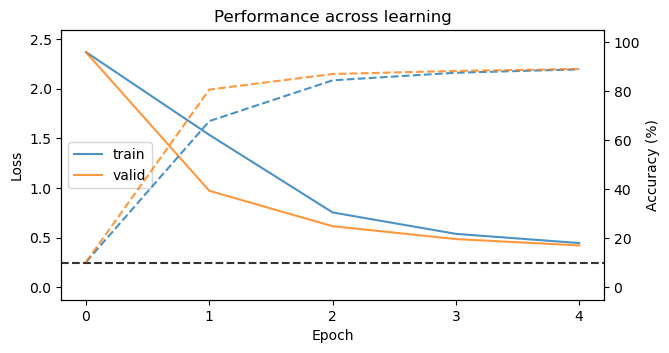

In [ ]:
plot_results(MLP_results_dict)

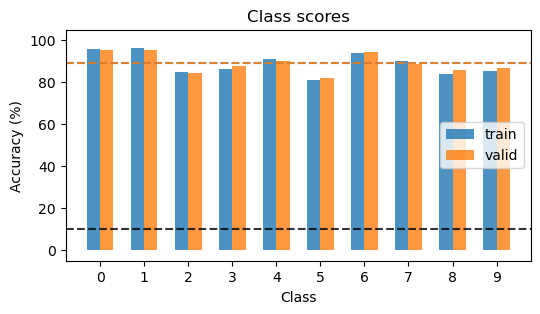

In [ ]:
plot_scores_per_class(MLP_results_dict);

array([<Axes: title={'center': 'First linear layer weights (pre, post and diff)'}, xlabel='Input dim.', ylabel='Output dim.'>,
       <Axes: title={'center': 'Second linear layer weights (pre, post and diff)'}, xlabel='Input dim.', ylabel='Output dim.'>],
      dtype=object)

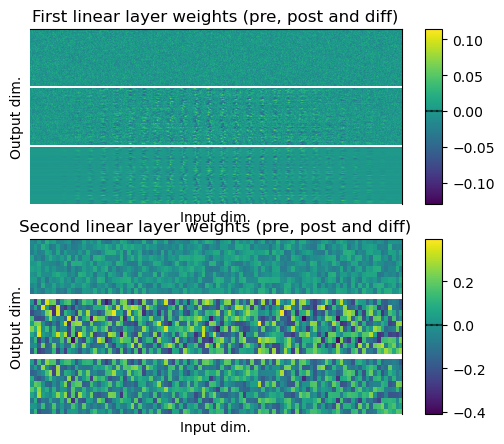

In [ ]:
plot_weights(MLP=MLP_Backprop)

In [ ]:
with plt.xkcd():
    plt.plot(losses_node_perturb, label="Node Perturbation", color='c')
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")
    plt.show()

In [66]:
NUM_INPUTS = np.product(train_set.dataset.data[0].shape) # size of an MNIST image
NUM_OUTPUTS = 10 # number of MNIST classesnum_inputs
print(NUM_INPUTS)

784


In [72]:
losses_node_backprop = np.zeros((numupdates,))
accuracy_node_backprop = np.zeros((numepochs,))

# set the random seed
rng_np = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
with contextlib.redirect_stdout(io.StringIO()):
    netbackprop = MLP(rng_np, sigma=initweight, activation=activation)
    (losses_node_backprop[:], accuracy_node_backprop[:], _, snr_node_backprop) = \
        netbackprop.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                             learning_rate=learnrate, batch_size=batchsize, noise=noise, \
                             report=report, report_rate=rep_rate)

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

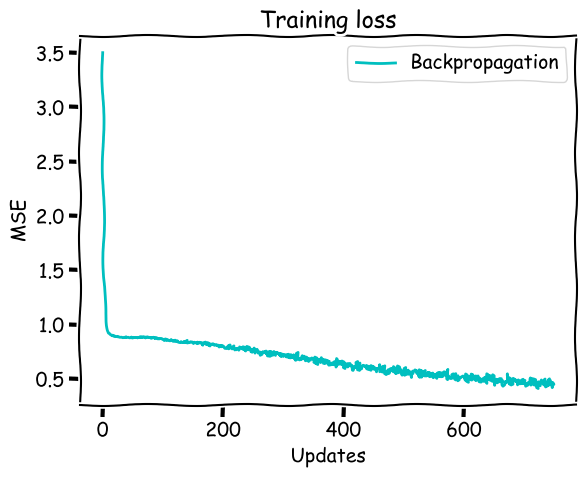

In [73]:
with plt.xkcd():
    plt.plot(losses_node_backprop, label="Backpropagation", color='c')
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")
    plt.show()